# Helper Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import torch
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import random
%matplotlib inline

In [2]:
def eval_policy(gamma,policy,T_list,R_list,theta):

    num_states = T_list[0].shape[0]

    index = list(zip(policy,range(num_states)))
    T=[]
    for t in T_list:
        T.append(t.tolist())

    T_pi = np.matrix([T[i][j] for (i,j) in index])

    #R = [mean_rewards_0,mean_rewards_1]
    #R_pi = np.transpose(np.matrix([R[i][j] for (i,j) in index]))
    R_pi = np.transpose(np.matrix(R_list))

    #value = np.dot(np.linalg.inv(np.eye(num_states)-gamma*T_pi),`R_pi)
    #value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,np.eye(num_states))@R_pi
    value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,R_pi)

    #TODO solve function much more stable
    #TODO code up value iteration to match
    return value

def policy_iter(gamma,T_list,R_list,theta):

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)

    #initialize value fucntion and policy arbitrarily
    value= np.random.uniform(0,1,num_states)
    value = np.transpose(np.matrix(value))
    #policy = [0]*num_states #TODO init policy randomly?.
    policy = np.random.binomial(n=1, p=0.5, size=[num_states]).tolist()
    counter = 0

    #policy improvement
    policy_stable = False
    max_iter = 10000
    i = 0

    while policy_stable ==False and i <max_iter:

        counter+=1

        old_policy = policy

        rewards_mat = np.transpose(np.matrix(R_list))

        a_list = []
        for a in range(num_actions):
            m = np.transpose(rewards_mat + T_list[a]@(gamma*value))
            a_list.append(m.tolist()[0])
        a_mat = np.transpose(np.matrix(a_list))

        policy = np.transpose(np.argmax(a_mat,axis=1))[0]
        policy = policy.tolist()[0]

        if policy == old_policy:
            policy_stable = True

        #policy evaluation
        value = eval_policy(gamma,policy,T_list,R_list,theta)
        value = np.matrix(value)
        i +=1

    return policy, value

def value_iter(gamma, T_list,R_list, theta = .001):
  """Value Iteration
  """
  num_states = T_list[0].shape[0]

  T = torch.tensor(np.array([np.array(x) for x in T_list]))
  R = torch.tensor(np.array(R_list))

  #V = torch.tensor(np.zeros(10))
  V = torch.tensor(np.random.uniform(0,1,num_states))
  delta = 10.

  while delta > theta:
      v = V
      #print(R + gamma*torch.einsum("bij,j->bi", T, V))
      V = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).values
      #print('V',V)
      #print('')
      delta= torch.max(torch.abs(v-V)).item()

  #get greedy policy
  P = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).indices

  return np.array(P),np.array(V)


# River Swim Environment

In [3]:
def define_mdp():
  """River swim environment

  from: https://papers.nips.cc/paper/2013/file/6a5889bb0190d0211a991f47bb19a777-Paper.pdf

  """
  R=np.array([[5./1000,0,0,0,0,0],[0,0,0,0,0,1]])
  num_states = len(R[0])

  T_left = np.zeros((num_states,num_states))
  T_left[0][0] = 1
  for s in range(1,num_states):
    T_left[s][s-1] = 1

  T_right = .6*np.eye(num_states)
  T_right[0][0] = .4
  T_right[0][1] = .6

  T_right[1][0] = .05
  T_right[1][2] = .35

  T_right[2][1] = .05
  T_right[2][3] = .35

  T_right[3][2] = .05
  T_right[3][4] = .35

  T_right[4][3] = .05
  T_right[4][5] = .35

  T_right[5][4] = .40

  return [T_left,T_right],R

In [4]:
T_list,R_list = define_mdp()

In [5]:
epsilon= .50
gamma = .999 # true discount factor

#average with zeros
T_zeros = np.matrix(np.zeros((6,6)))
T_reg_zeros = []
for T_i in T_list:
  T_reg_zeros.append((1-epsilon)*T_i + epsilon*T_zeros)

#average with uniform
T_unif = np.matrix([.10*np.ones(6) for i in range(6)])
T_reg_unif = []
for T_i in T_list:
  T_reg_unif.append((1-epsilon)*T_i + epsilon*T_unif)

p1,v1=value_iter(gamma,T_reg_unif,R_list)
print(p1)
print(v1)

p2,v2=value_iter(gamma,T_reg_zeros,R_list)
print(p2)
print(v2)


print(max(v1))
print(max(v2))

[0 1 1 1 1 1]
[0.52028517 0.51679306 0.53489887 0.60792495 0.89786048 2.04882879]
[0 1 1 1 1 1]
[0.0108611  0.0066249  0.02422057 0.09691497 0.38672211 1.53767756]
2.0488287903249605
1.5376775648247358


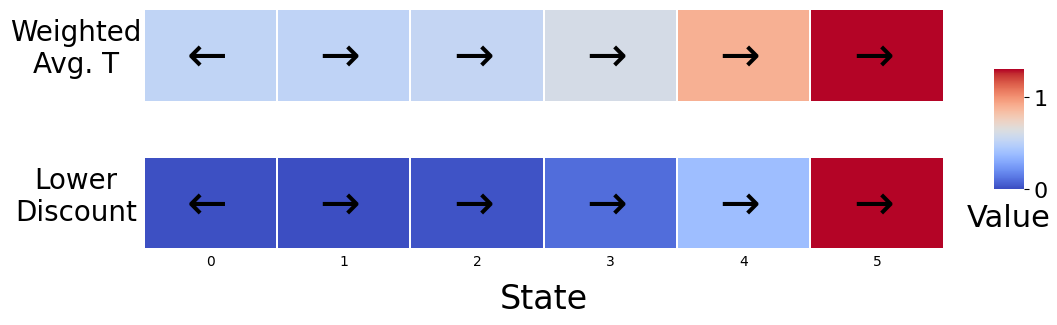

In [6]:
fig, ax = plt.subplots(2,1,figsize=(10,3), sharex=True,sharey=True)
cbar_ax = fig.add_axes([0.95, .3, .03, .4])

sns.heatmap(v1.reshape((1,6)), ax=ax[0], cbar= 0, vmin=0, vmax= 1.3, cbar_ax=None,linewidths=0.1, linecolor='white',cmap = 'coolwarm')
sns.heatmap(v2.reshape((1,6)), ax=ax[1], cbar= 1, vmin=0, vmax= 1.3, cbar_ax=cbar_ax,linewidths=0.1, linecolor='white',cmap = 'coolwarm')

#ax[0].set_title('Uniform')
#ax[1].set_title('Discount')
ax[0].set_ylabel(r"Weighted" "\n" "Avg. T",fontsize=20,rotation=0)
ax[1].set_ylabel(r"Lower" "\n" "Discount",fontsize=20,rotation=0)
ax[0].yaxis.set_label_coords(-0.085, 0.25)
ax[1].yaxis.set_label_coords(-0.085, 0.25)
ax[1].set_xlabel('State', labelpad=10,fontsize=24)
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].tick_params(axis=u'both', which=u'both',length=0)
ax[1].tick_params(axis=u'both', which=u'both',length=0)
#fig.tight_layout(rect=[0, 0, .9, 1])

cbar_ax.tick_params(labelsize=16)
cbar_ax.set_xlabel('Value',fontsize=22,labelpad=10)

#arrows for policy
ax[0].text(.25,.65,r"$\leftarrow$",fontsize=35)
ax[0].text(1.25,.65,r"$\rightarrow$",fontsize=35)
ax[0].text(2.25,.65,r"$\rightarrow$",fontsize=35)
ax[0].text(3.25,.65,r"$\rightarrow$",fontsize=35)
ax[0].text(4.25,.65,r"$\rightarrow$",fontsize=35)
ax[0].text(5.25,.65,r"$\rightarrow$",fontsize=35)

ax[1].text(.25,.65,r"$\leftarrow$",fontsize=35)
ax[1].text(1.25,.65,r"$\rightarrow$",fontsize=35)
ax[1].text(2.25,.65,r"$\rightarrow$",fontsize=35)
ax[1].text(3.25,.65,r"$\rightarrow$",fontsize=35)
ax[1].text(4.25,.65,r"$\rightarrow$",fontsize=35)
ax[1].text(5.25,.65,r"$\rightarrow$",fontsize=35)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)


#plt.savefig("heatmap.pdf",dpi=800,bbox_inches="tight")